## TOC:
   1. [Load the Modules](#first-bullet)
   2. [Load, Examine and Explore the Data](#second-bullet)
   3. [Plotting some Example](#second1-bullet)
   4. [Creating model](#4-bullet)
   5. [Training the model](#5-bullet)
   6. [Visualizing Loss and Accuracy](#6-bullet)
   7. [Predictings Image](#7-bullet)

# 1. Load the Modules <a class="anchor" id="first-bullet"></a>

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Load the Data, Examine and Explore <a class="anchor" id="second-bullet"></a>

In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir = pathlib.Path('/datasets/utk-face/')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

23708


In [4]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
for f in list_ds.take(5):
    print(f.numpy())

b'/datasets/utk-face/45_0_1_20170113184246839.jpg.chip.jpg'
b'/datasets/utk-face/40_0_0_20170116225114199.jpg.chip.jpg'
b'/datasets/utk-face/70_0_1_20170117174954253.jpg.chip.jpg'
b'/datasets/utk-face/5_1_0_20170109192408726.jpg.chip.jpg'
b'/datasets/utk-face/2_0_4_20170103205108602.jpg.chip.jpg'


In [6]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

18967
4741


In [7]:
# Functions to load and process images

def get_label(file_path):
    file = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(file, '_')[0]
    label = tf.strings.to_number(label, tf.int32)
    return label

def read_n_decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def process_path(file_path):
    label = get_label(file_path)
    img = read_n_decode_img(file_path)
    return img, label

In [8]:
train_ds = train_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [9]:
print(type(train_ds))
print(type(val_ds))
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
(32, 180, 180, 3)
(32,)


# 3. Plotting some Examples <a class="anchor" id="second1-bullet"></a>

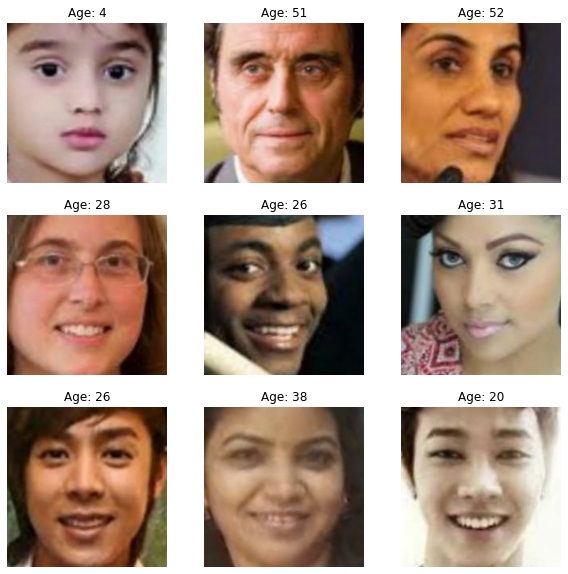

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Age: {}'.format(labels[i].numpy()))
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# 4. Creating model <a class="anchor" id="4-bullet"></a>
Here we're using Convolutional Neural Network (CNN)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

# 5. Training the model <a class="anchor" id="5-bullet"></a>

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
593/593 [==============================] - 55s 81ms/step - loss: 527.7134 - val_loss: 170.1561
Epoch 2/10
593/593 [==============================] - 48s 79ms/step - loss: 136.5027 - val_loss: 127.6134
Epoch 3/10
242/593 [===========>..................] - ETA: 23s - loss: 109.7236

KeyboardInterrupt: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                                 
 flatten (Flatten)           (None, 506944)            0

# 6. Visualizing Loss and Accuracy <a class="anchor" id="6-bullet"></a>

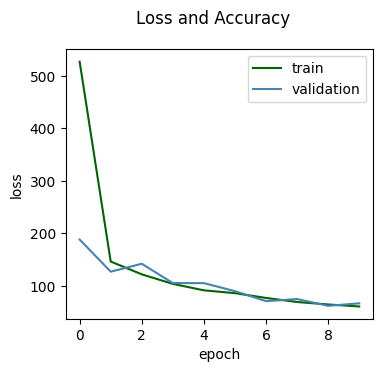

In [ ]:
fig, ax1 = plt.subplots(1, 1, dpi=100)
fig.suptitle('Loss and Accuracy')
fig.tight_layout()
fig.set_size_inches(3.5, 3.5, forward=True)

ax1.plot(history.history['loss'], color="darkgreen")
ax1.plot(history.history['val_loss'], color="steelblue")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'validation'], loc='upper right')

# 7. Predicting Images <a class="anchor" id="7-bullet"></a>

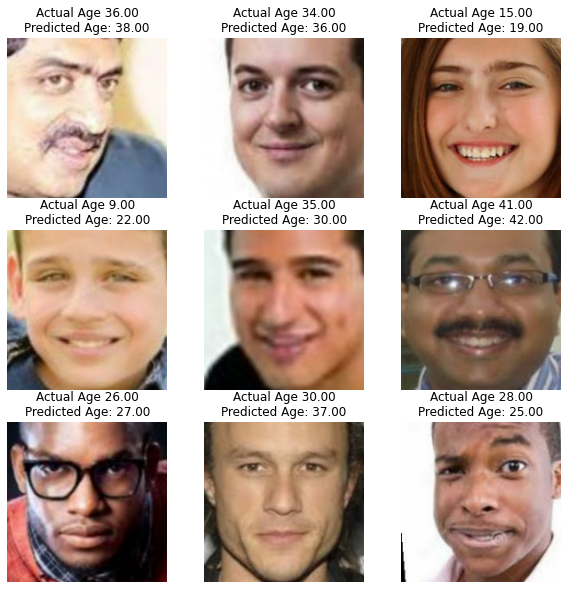

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        img = images[i].numpy().astype("uint8")
        pred = model.predict(
            img.reshape(1, img_height, img_width, 3),
            verbose=0
        )[0]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Actual Age {:.2f}\nPredicted Age: {:.2f}'.format(int(labels[i]), int(round(pred[0]))))
        plt.axis("off")

# Conclusión
* As can be seen, around epoch 18, the model begins to stop learning and possibly begins to overfit, this can be treated by making improvements to the model design.

* Another interesting aspect that can be dealt with is the complexity in the prediction of children's faces, which, as can be seen, neither of the two classes has a clear advantage over the other.

In [ ]:
serialize model to JSON
model_json = model.to_json()
with open("model/age-prediction/model.json", "w") as json_file:
    json_file.write(model_json)
serialize weights to HDF5
model.save_weights("model/age-prediction/model.h5")
print("Saved model to disk")